# WSM Model

In [1]:
## First some standar imports
import numpy as np
import matplotlib
import kwant
import kwant.continuum
from matplotlib import pyplot as plt
from ipywidgets import *
import tinyarray
import scipy.linalg as la
%matplotlib inline
plt.rcParams.update({'font.size': 12})

In [2]:
# Let's define the Pauli matrices
sigma_0 = tinyarray.array([[1, 0], [0, 1]])
sigma_x = tinyarray.array([[0, 1], [1, 0]])
sigma_y = tinyarray.array([[0, -1j], [1j, 0]])
sigma_z = tinyarray.array([[1, 0], [0, -1]])

##### - Let's start by defining the system


In order to show another way to build systems in kwant, will use kwant.continuum wich allows to introduce a continuum Hamiltonian and obtain a discretized version directly.

We will use the continuum Hamiltonian:

\begin{equation}
    H =k_x \sigma_x + k_y \sigma_y+ \left(\frac{1 - k_x^2-k_y^2- k_z^2}{2}\right)\sigma_z.
\end{equation}

In [3]:
def make_model(a):
    ham = ("(k_x * sigma_x + k_y * sigma_y)"
           "+ 0.5*(1.-(k_x**2 + k_y**2+ k_z**2)) * sigma_z")
    return kwant.continuum.discretize(ham, grid=a)

def WSM_syst(L):
    model = make_model(a = 1);
    lat = kwant.lattice.cubic(a = 1)
    if L ==None:
        sym = kwant.TranslationalSymmetry(lat.vec((1, 0,0)), lat.vec((0, 1,0)),lat.vec((0, 0,1)))
        syst = kwant.Builder(sym)
        syst=kwant.wraparound.wraparound(model)
    else:
        def shape(site):
            x, y, z = site.pos
            return abs(y) < L/2
        sym = kwant.TranslationalSymmetry(lat.vec((1, 0, 0)), lat.vec((0, 0,1)))
        syst = kwant.Builder(sym)
        syst.fill(model, shape, (0,0,0))
        syst=kwant.wraparound.wraparound(syst, coordinate_names=['x', 'z'])
    return syst.finalized()

#### -First we study the bulk dispersion:
It shows two Weyl nodes located at $k = (0,0,\pm 1)$

In [4]:
bulk = WSM_syst(L= None)

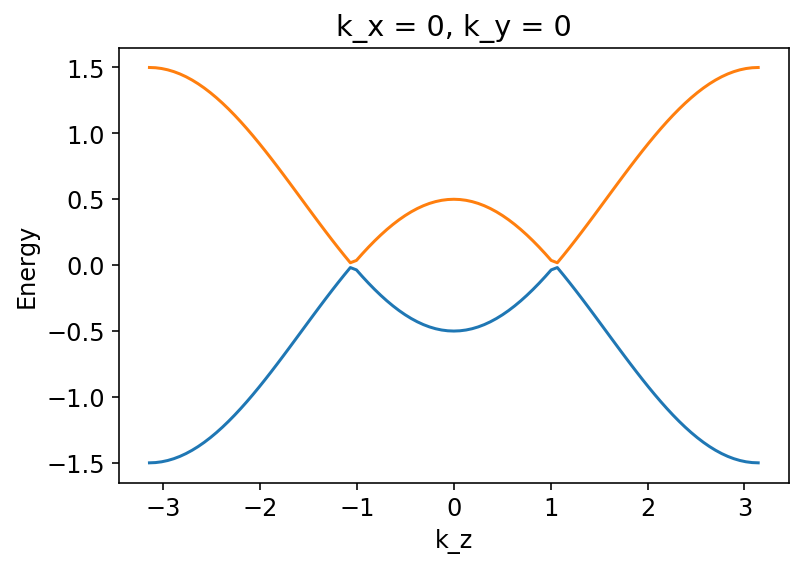

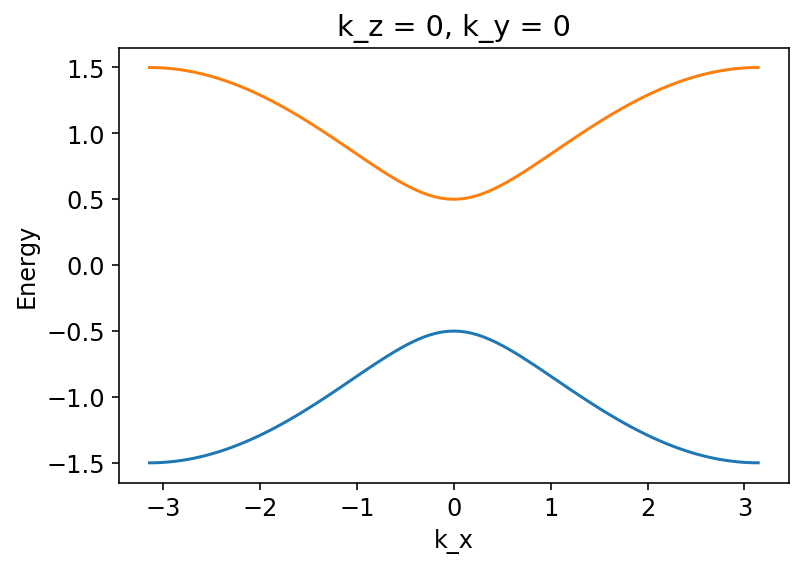

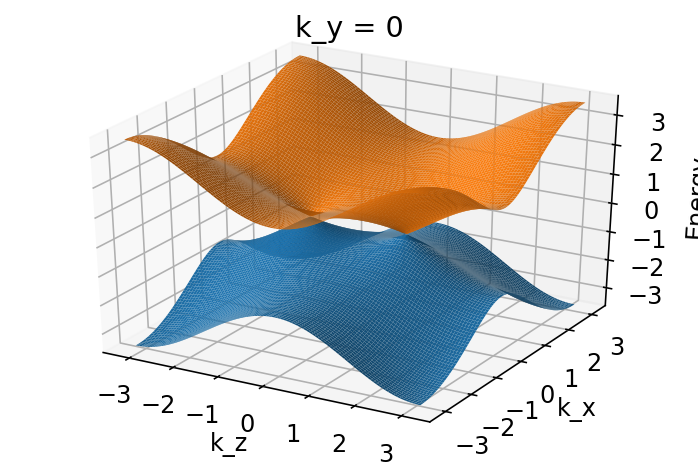

In [5]:
momenta = np.linspace(-np.pi, np.pi, 101)
kwant.plotter.spectrum(bulk, ("k_z", momenta), params=dict( k_x=0,k_y=0));
kwant.plotter.spectrum(bulk, ("k_x", momenta), params=dict( k_z=0,k_y=0));
kwant.plotter.spectrum(bulk, ("k_z", momenta), ("k_x", momenta), params=dict( k_y=0));

#### -In a finite system (finite along the y direction)
The bands of the surface states arise due to the bulk-boundary correspondence

In [6]:
WSM_strip = WSM_syst(L= 100)

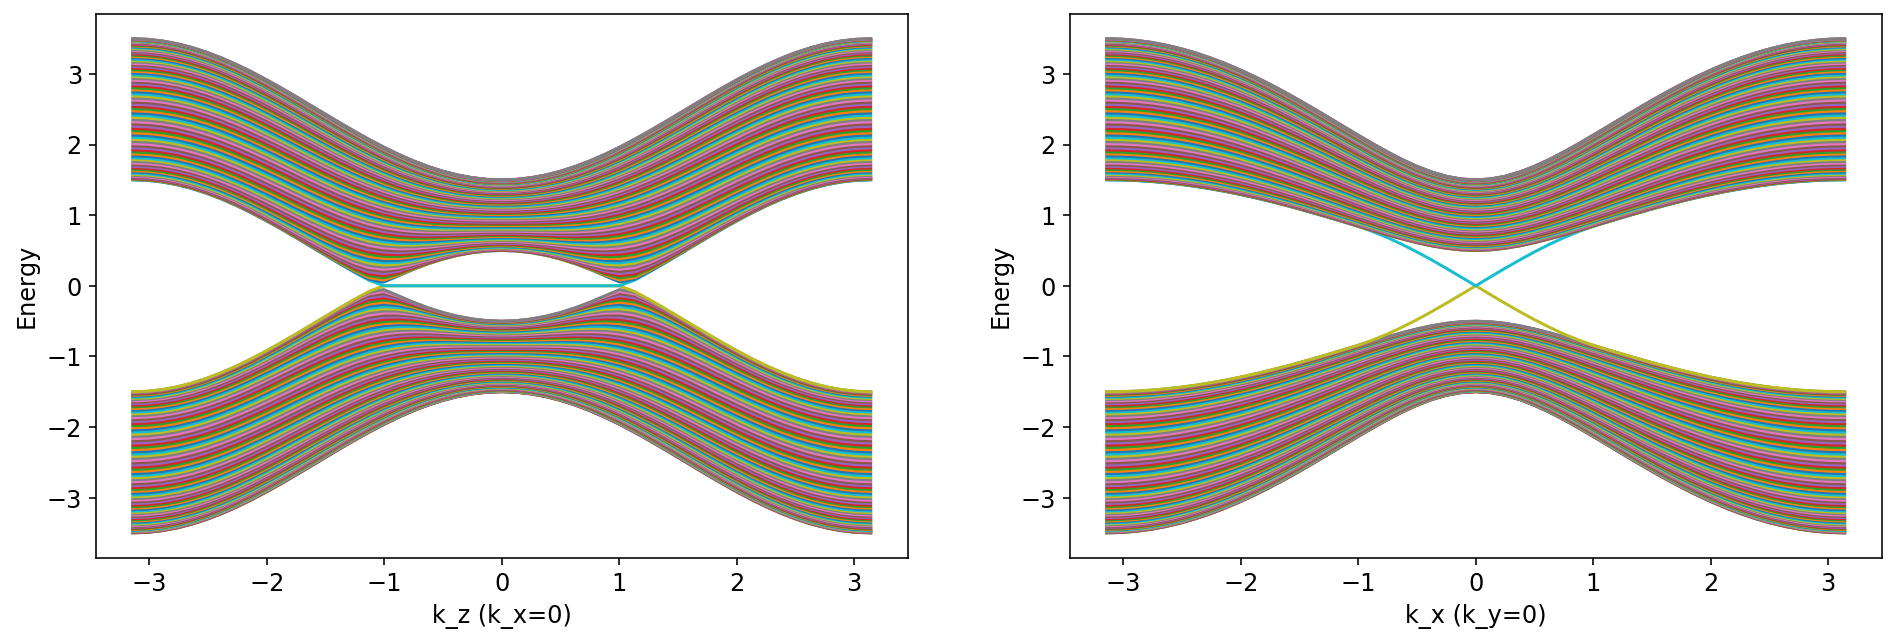

In [7]:
fig = plt.figure(figsize=(16, 5))
ax1 = fig.add_subplot(121); ax2 = fig.add_subplot(122);

momenta = np.linspace(-np.pi, np.pi, 51)
kwant.plotter.spectrum(WSM_strip, ("k_z", momenta), params=dict( k_x=0), ax = ax1);
ax1.set_xlabel('k_z (k_x=0)'); ax1.set_ylabel('Energy')

kwant.plotter.spectrum(WSM_strip, ("k_x", momenta), params=dict( k_z=0), ax = ax2);
ax2.set_xlabel('k_x (k_y=0)'); ax2.set_ylabel('Energy')

plt.show();


#### Now let's plot the central state as a function of the momenta k_z

In [8]:
density = kwant.operator.Density(WSM_strip)
def calc_bs_wfs_kz(syst, momenta, params):
    energies = []
    wfs = []
    for k in momenta:
        ham = syst.hamiltonian_submatrix(params=dict(k_z=k, **params))
        evals, evecs = la.eigh(ham)
        energies.append(evals)
        wfs.append(evecs)
    return energies, wfs

In [9]:
moms = np.linspace(-np.pi, np.pi, 11)
ens, wfs = calc_bs_wfs_kz(WSM_strip, moms, params= dict(k_x=0))

In [10]:
def plot_states(j):
    n = int(ens[0].shape[0]/2)
    
    # The bands:
    fig = plt.figure(figsize=(14, 5))
    ax1 = fig.add_subplot(121); ax2 = fig.add_subplot(122); 
    kwant.plotter.spectrum(WSM_strip, ("k_z", momenta), params=dict( k_x=0), ax = ax1);
    ax1.axvline(x = moms[j], color= 'k', ls = '--'); ax1.plot(moms[j], ens[j][n], 'ko')
    # The states:
    ax2.plot(density(wfs[j][:,n]), )
    ax2.set_ylabel(r'$|\psi|^2$'); ax2.set_xlabel('z');
    plt.show();

In [11]:
interact(plot_states, j=widgets.IntSlider(min=0, max=len(moms)-1, step=1, value=len(moms)//2));

interactive(children=(IntSlider(value=5, description='j', max=10), Output()), _dom_classes=('widget-interact',…